In [2]:
import os 
import sys
import random
import math
import numpy as np
import cv2
import matplotlib.pyplot as plt
import json
import pydicom
from imgaug import augmenters as iaa
from tqdm import tqdm
import pandas as pd 
import glob 

%matplotlib inline

In [3]:
import mdai
mdai.__version__

'0.0.5'

In [4]:
ROOT_DIR = '/projects/lungbox'

sys.path.append(os.path.join(ROOT_DIR)) 
import src.ingestion as ingest

In [5]:
# Import Mask RCNN
sys.path.append(os.path.join(ROOT_DIR, 'libs/Mask_RCNN'))  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

Using TensorFlow backend.


In [6]:
# Config
S3_BUCKET_NAME = 'lungbox'
os.environ['AWS_REGION'] = 'us-west-2'

S3_CLASS_INFO_KEY = 'data/raw/stage_1_detailed_class_info.csv'
S3_TRAIN_BOX_KEY = 'data/raw/stage_1_train_labels.csv'
S3_CLASS_INFO_PATH = 's3://' + S3_BUCKET_NAME + '/' + S3_CLASS_INFO_KEY
S3_TRAIN_BOX_PATH = 's3://' + S3_BUCKET_NAME + '/' + S3_TRAIN_BOX_KEY

S3_STAGE1_TRAIN_IMAGE_DIR = 'data/raw/stage_1_train_images'
S3_STAGE1_TEST_IMAGE_DIR = 'data/raw/stage_1_test_images'

# Original DICOM image size: 1024 x 1024
ORIG_SIZE = 1024

In [7]:
def parse_training_labels(train_box_df, train_image_dirpath):
    """
    Method to read a CSV file (Pandas dataframe) and parse the
    data into the following nested dictionary:

      parsed = {
        'patientId-00': {
            'dicom': path/to/dicom/file,
            'label': either 0 or 1 for normal or pnuemonia,
            'boxes': list of box(es)
        },
        'patientId-01': {
            'dicom': path/to/dicom/file,
            'label': either 0 or 1 for normal or pnuemonia,
            'boxes': list of box(es)
        }, ...
      }

    References:
    * Exploratory Data Analysis, by Peter Chang, MD.
        - Available at https://www.kaggle.com/peterchang77/exploratory-data-analysis/notebook
        - Retrieved 2018-09-19
    """
    # Define lambda to extract coords in list [y, x, height, width]
    def extract_box(row):
        return [row['y'], row['x'], row['height'], row['width']]

    parsed = {}
    for n, row in train_box_df.iterrows():
        # Initialize patient entry into parsed
        pid = row['patientId']
        if pid not in parsed:
            parsed[pid] = {
                'dicom_s3_key': train_image_dirpath + '/%s.dcm' % pid,
                'label': row['Target'],
                'boxes': []}

        # Add box if opacity is present
        if parsed[pid]['label'] == 1:
            parsed[pid]['boxes'].append(extract_box(row))

    return parsed


In [8]:
train_box_df = ingest.read_s3_df(
    bucket_name=S3_BUCKET_NAME, file_key=S3_TRAIN_BOX_KEY)
annotation_dict = parse_training_labels(
    train_box_df=train_box_df,
    train_image_dirpath=S3_STAGE1_TRAIN_IMAGE_DIR)

In [9]:
print(annotation_dict['0004cfab-14fd-4e49-80ba-63a80b6bddd6'])
print(annotation_dict['00436515-870c-4b36-a041-de91049b9ab4'])

{'dicom_s3_key': 'data/raw/stage_1_train_images/0004cfab-14fd-4e49-80ba-63a80b6bddd6.dcm', 'label': 0, 'boxes': []}
{'dicom_s3_key': 'data/raw/stage_1_train_images/00436515-870c-4b36-a041-de91049b9ab4.dcm', 'label': 1, 'boxes': [[152.0, 264.0, 379.0, 213.0], [152.0, 562.0, 453.0, 256.0]]}


In [10]:
image_df = ingest.parse_dicom_image_list(bucket_name=S3_BUCKET_NAME) # slow
image_df.head()

,path,subdir,patient_id
0,lungbox/data/raw/stage_1_test_images/000924cf-...,test,000924cf-0f8d-42bd-9158-1af53881a557
1,lungbox/data/raw/stage_1_test_images/000db696-...,test,000db696-cf54-4385-b10b-6b16fbb3f985
2,lungbox/data/raw/stage_1_test_images/000fe35a-...,test,000fe35a-2649-43d4-b027-e67796d412e0
3,lungbox/data/raw/stage_1_test_images/001031d9-...,test,001031d9-f904-4a23-b3e5-2c088acd19c6
4,lungbox/data/raw/stage_1_test_images/0010f549-...,test,0010f549-b242-4e94-87a8-57d79de215fc


In [11]:
# Take subset of 100
patient_id_subset = list(image_df[image_df['subdir'] == 'train']['patient_id'][:100])
len(patient_id_subset)

100

In [12]:
# The following parameters have been selected to reduce running time for demonstration purposes 
# These are not optimal 

class DetectorConfig(Config):
    """Configuration for training pneumonia detection on the RSNA pneumonia dataset.
    Overrides values in the base Config class.
    """
    
    # Give the configuration a recognizable name  
    NAME = 'pneumonia'
    
    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 8 
    
    BACKBONE = 'resnet50'
    
    NUM_CLASSES = 2  # background + 1 pneumonia classes
    
    IMAGE_MIN_DIM = 256
    IMAGE_MAX_DIM = 256
    RPN_ANCHOR_SCALES = (32, 64, 128, 256)
    TRAIN_ROIS_PER_IMAGE = 32
    MAX_GT_INSTANCES = 3
    DETECTION_MAX_INSTANCES = 3
    DETECTION_MIN_CONFIDENCE = 0.9
    DETECTION_NMS_THRESHOLD = 0.1

    STEPS_PER_EPOCH = 100
    
config = DetectorConfig()
config.display()



Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     8
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        3
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.1
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 8
IMAGE_MAX_DIM                  256
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  256
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [256 256   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES   

In [13]:
import boto3
from io import BytesIO
S3_CLIENT = boto3.client('s3')      # low-level functional API
def get_s3_dcm(bucket, key):
    """Read DICOM from S3"""
    obj = S3_CLIENT.get_object(Bucket=bucket, Key=key)
    return pydicom.read_file(BytesIO(obj['Body'].read()))

In [16]:
class DetectorDataset(utils.Dataset):
    """Dataset class for training pneumonia detection on the RSNA pneumonia dataset.
    """

    def __init__(self, patient_ids, annotation_dict, orig_height, orig_width, s3_bucket):
        super().__init__(self)
        self.s3_bucket = s3_bucket

        # Add classes
        self.add_class('pneumonia', 1, 'Lung Opacity')

        # Add images
        for i, patient_id in enumerate(patient_ids):
            self.add_image('pneumonia',
                           image_id=i,
                           path=annotation_dict[patient_id]['dicom_s3_key'],
                           annotations=annotation_dict[patient_id]['boxes'],
                           orig_height=orig_height,
                           orig_width=orig_width)

    def get_image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path']

    def get_image_annotation(self, image_id):
        info = self.image_info[image_id]
        return info['annotations']
        
    def load_image(self, image_id):
        info = self.image_info[image_id]
        ds = get_s3_dcm(bucket=self.s3_bucket, key=info['path'])
        image = ds.pixel_array
        # If grayscale. Convert to RGB for consistency.
        if len(image.shape) != 3 or image.shape[2] != 3:
            image = np.stack((image,) * 3, -1)
        return image

    def load_mask(self, image_id):
        info = self.image_info[image_id]
        annotations = info['annotations']
        number_of_boxes = len(annotations)
        if number_of_boxes == 0:
            mask = np.zeros(
                (info['orig_height'], info['orig_width'], 1), dtype=np.uint8)
            class_ids = np.zeros((1,), dtype=np.int32)
        else:
            mask = np.zeros(
                (info['orig_height'], info['orig_width'], number_of_boxes), dtype=np.uint8)
            class_ids = np.zeros((number_of_boxes,), dtype=np.int32)
            for i, box in enumerate(annotations):
                x = int(box[0])
                y = int(box[1])
                w = int(box[2])
                h = int(box[3])
                mask_instance = mask[:, :, i].copy()
                cv2.rectangle(mask_instance, (x, y),
                              (x + w, y + h), 255, -1)
                mask[:, :, i] = mask_instance
                class_ids[i] = 1
        return mask.astype(np.bool), class_ids.astype(np.int32)

In [14]:
# split dataset into training vs. validation dataset 
# split ratio is set to 0.9 vs. 0.1 (train vs. validation, respectively)
sorted(patient_id_subset)
random.seed(42)
random.shuffle(patient_id_subset)

validation_split = 0.1
split_index = int((1 - validation_split) * len(patient_id_subset))

patient_id_train = patient_id_subset[:split_index]
patient_id_valid = patient_id_subset[split_index:]

print(len(patient_id_train), len(patient_id_valid))

90 10


In [17]:
# prepare the training dataset
dataset_train = DetectorDataset(patient_id_train, annotation_dict, ORIG_SIZE, ORIG_SIZE, S3_BUCKET_NAME)
dataset_train.prepare()
assert len(dataset_train.image_ids) == len(patient_id_train)

# prepare the validation dataset
dataset_valid = DetectorDataset(patient_id_valid, annotation_dict, ORIG_SIZE, ORIG_SIZE, S3_BUCKET_NAME)
dataset_valid.prepare()
assert len(dataset_valid.image_ids) == len(patient_id_valid)

In [18]:
dataset_train.image_info[:5]

[{'id': 0,
  'source': 'pneumonia',
  'path': 'data/raw/stage_1_train_images/01c0b605-0a82-401b-9649-81252304ac45.dcm',
  'annotations': [],
  'orig_height': 1024,
  'orig_width': 1024},
 {'id': 1,
  'source': 'pneumonia',
  'path': 'data/raw/stage_1_train_images/01c09fb1-a917-46ee-8d94-44f844a4eb85.dcm',
  'annotations': [],
  'orig_height': 1024,
  'orig_width': 1024},
 {'id': 2,
  'source': 'pneumonia',
  'path': 'data/raw/stage_1_train_images/035789b1-3736-405d-9910-f8f23c62ae9f.dcm',
  'annotations': [[338.0, 692.0, 191.0, 140.0], [352.0, 239.0, 93.0, 121.0]],
  'orig_height': 1024,
  'orig_width': 1024},
 {'id': 3,
  'source': 'pneumonia',
  'path': 'data/raw/stage_1_train_images/009482dc-3db5-48d4-8580-5c89c4f01334.dcm',
  'annotations': [],
  'orig_height': 1024,
  'orig_width': 1024},
 {'id': 4,
  'source': 'pneumonia',
  'path': 'data/raw/stage_1_train_images/01fdfd88-7607-48b9-ba05-a36e8b6fd19b.dcm',
  'annotations': [[437.0, 319.0, 289.0, 170.0], [449.0, 669.0, 284.0, 162.0

In [19]:
# Load and display a sample and its bounding box
image_id=2
print(annotation_dict['035789b1-3736-405d-9910-f8f23c62ae9f'])
image_fp = dataset_train.image_reference(image_id)
print(dataset_train.get_image_reference(image_id))
print(dataset_train.get_image_annotation(image_id))

{'dicom_s3_key': 'data/raw/stage_1_train_images/035789b1-3736-405d-9910-f8f23c62ae9f.dcm', 'label': 1, 'boxes': [[338.0, 692.0, 191.0, 140.0], [352.0, 239.0, 93.0, 121.0]]}
data/raw/stage_1_train_images/035789b1-3736-405d-9910-f8f23c62ae9f.dcm
[[338.0, 692.0, 191.0, 140.0], [352.0, 239.0, 93.0, 121.0]]


In [20]:
image_fp = dataset_train.image_reference(image_id=image_id)
image = dataset_train.load_image(image_id=image_id)
mask, class_ids = dataset_train.load_mask(image_id=image_id)
print(class_ids)
print(image.shape)

[1 1]
(1024, 1024, 3)


(-0.5, 1023.5, 1023.5, -0.5)

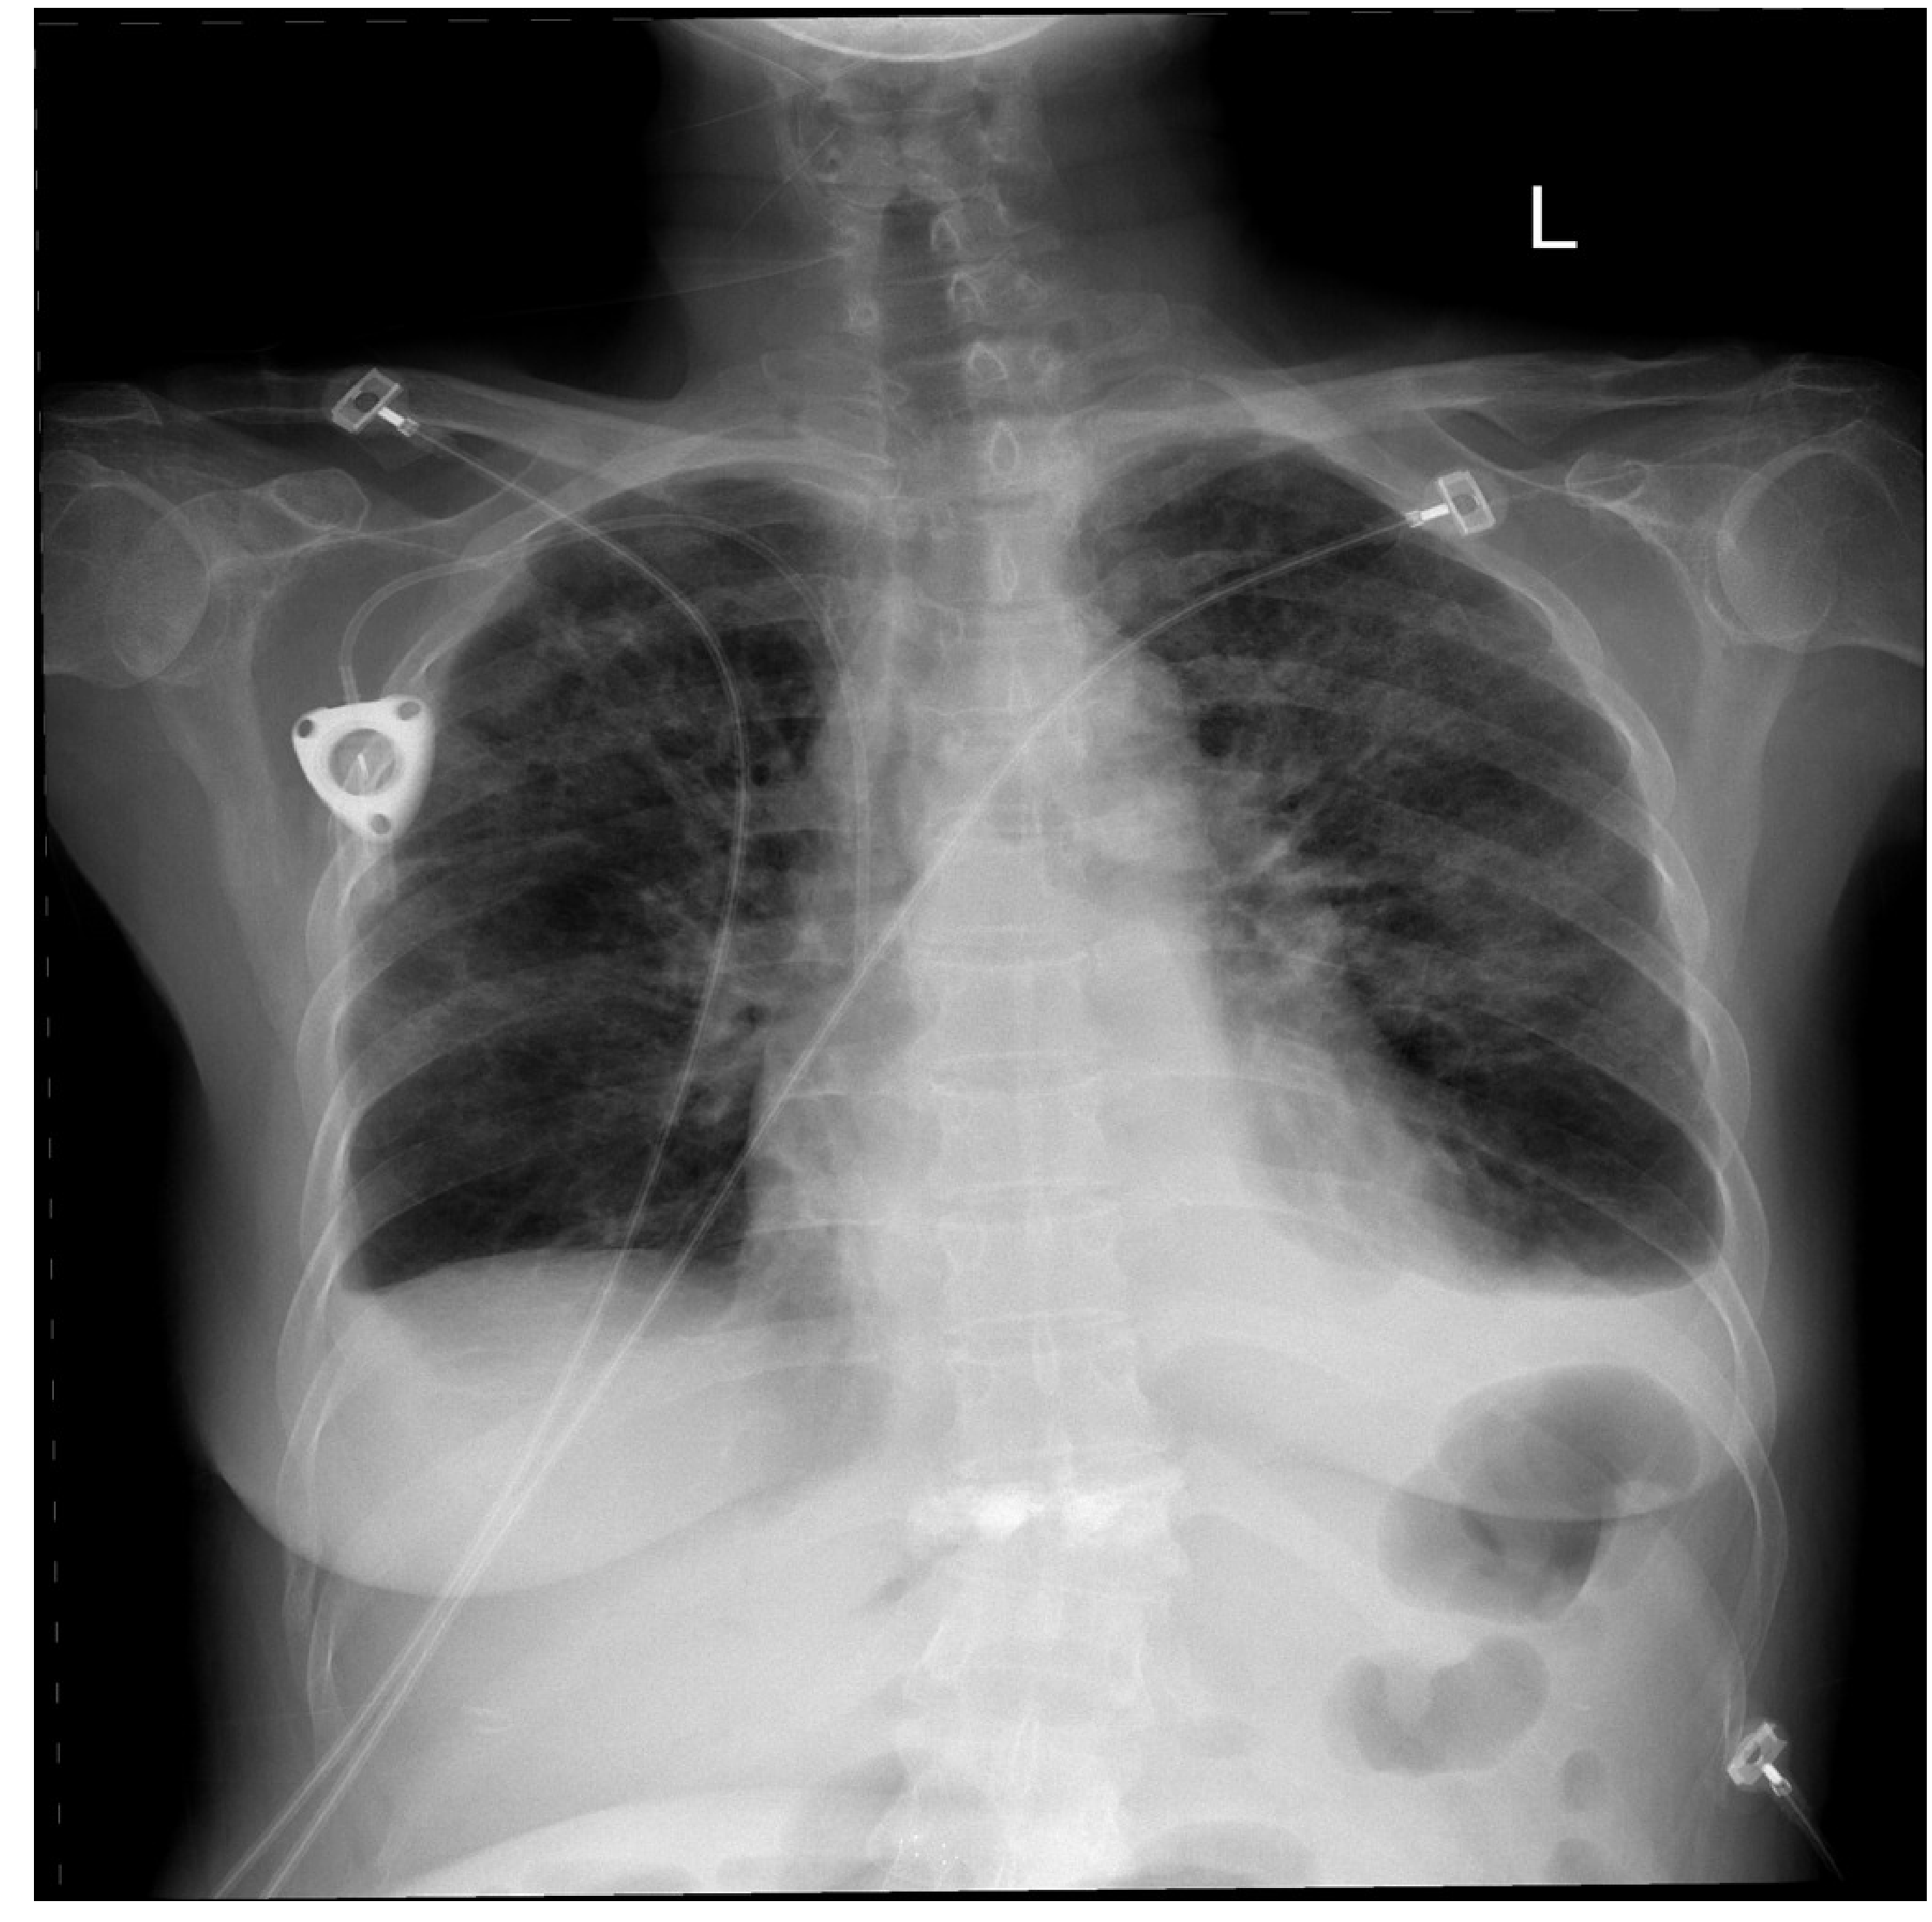

In [24]:
plt.figure(figsize=(40, 40))
plt.imshow(image[:, :, 0], cmap='gray')
plt.axis('off')


[1 1]


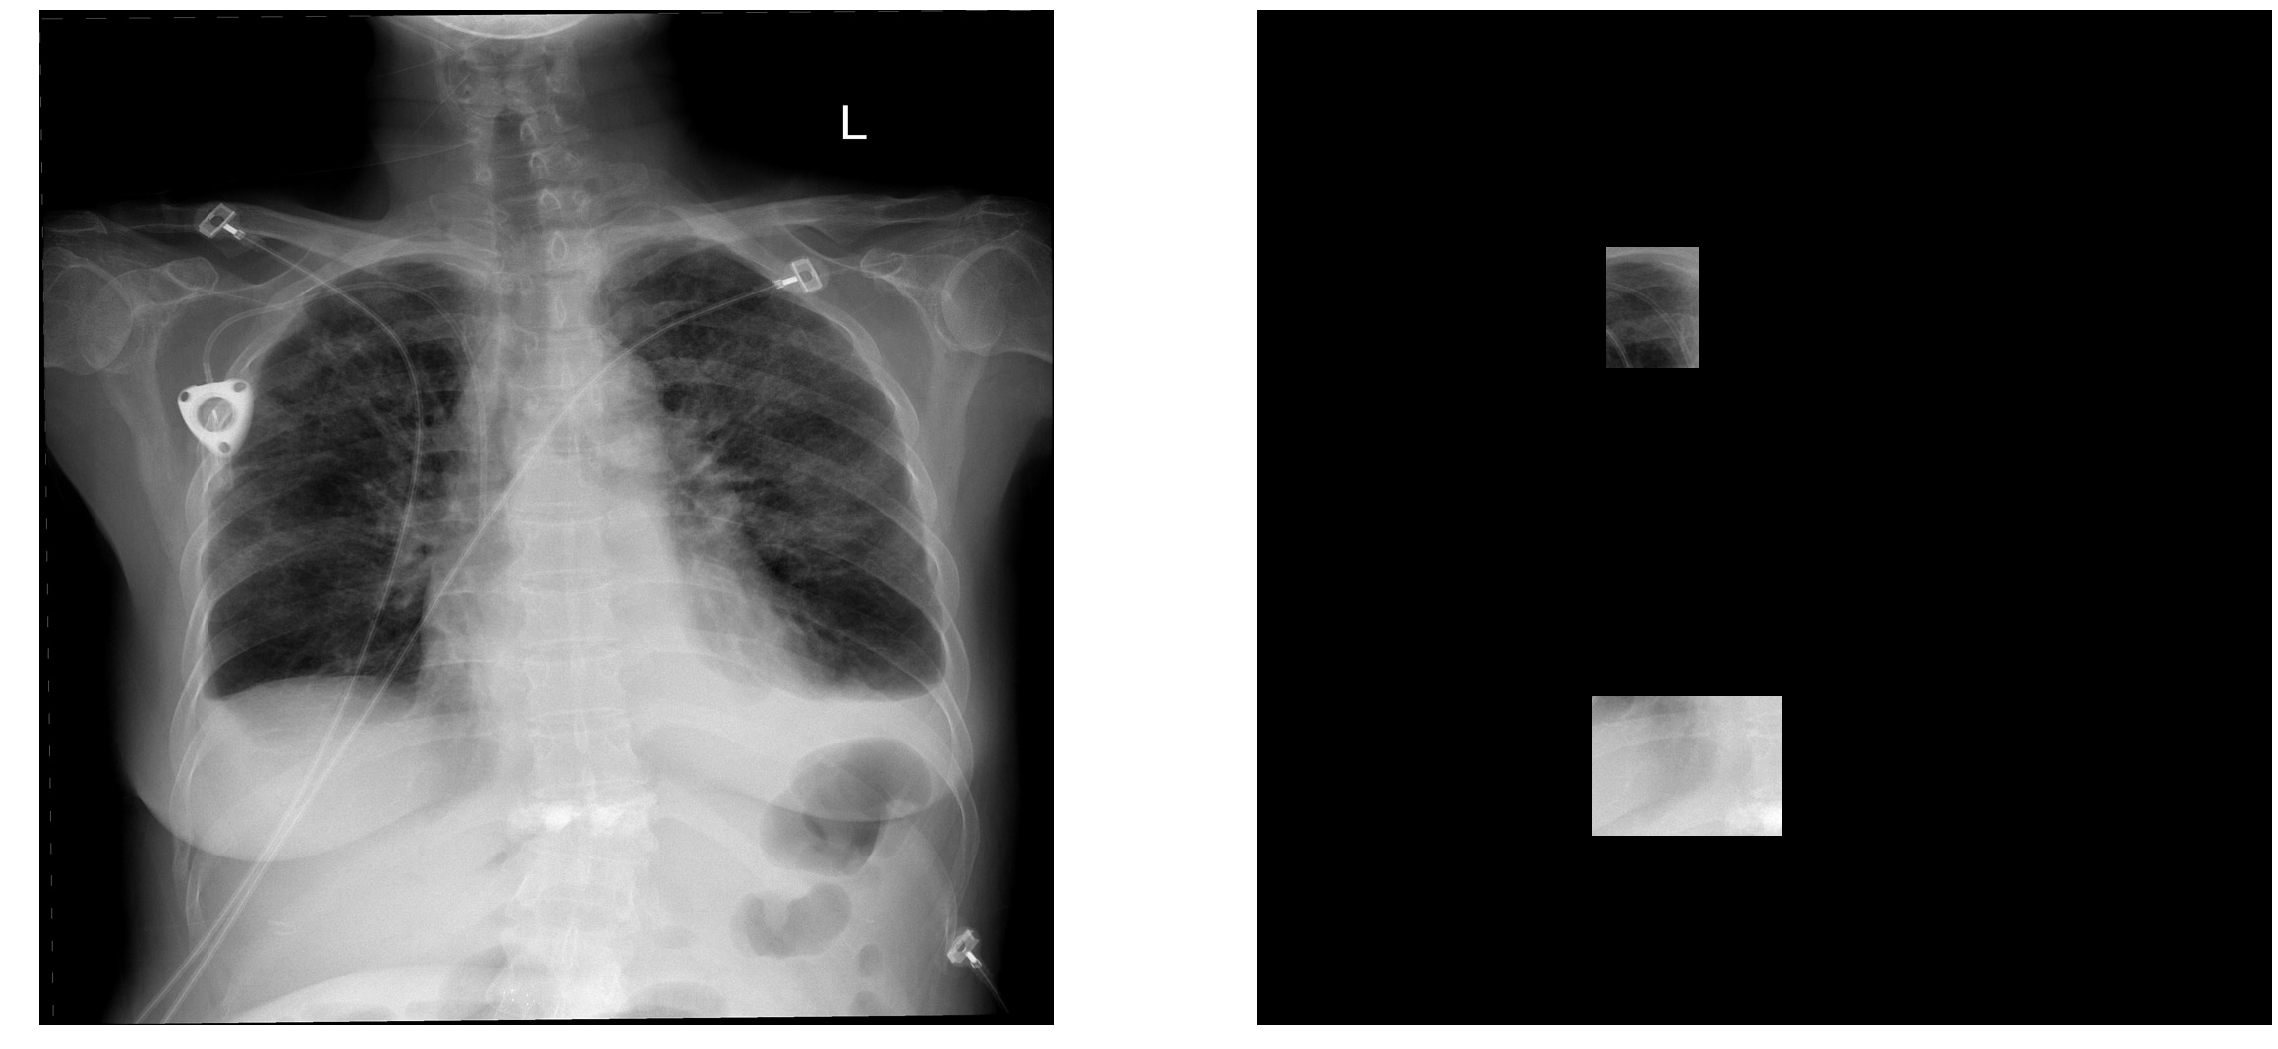

In [23]:
plt.figure(figsize=(40, 40))
plt.subplot(1, 2, 1)
plt.imshow(image[:, :, 0], cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
masked = np.zeros(image.shape[:2])
for i in range(mask.shape[2]):
    masked += image[:, :, 0] * mask[:, :, i]
plt.imshow(masked, cmap='gray')
plt.axis('off')

print(image_fp)
print(class_ids)

In [41]:
model = modellib.MaskRCNN(mode='training', config=config, model_dir=ROOT_DIR)

In [57]:
# Image augmentation 
augmentation = iaa.SomeOf((0, 1), [
    iaa.Fliplr(0.5),
    iaa.Affine(
        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
        translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
        rotate=(-25, 25),
        shear=(-8, 8)
    ),
    iaa.Multiply((0.9, 1.1))
])

In [58]:
NUM_EPOCHS = 1

# Train Mask-RCNN Model 
# import warnings 
# warnings.filterwarnings("ignore")
model.train(train_dataset=dataset_train,
            val_dataset=dataset_valid, 
            learning_rate=config.LEARNING_RATE, 
            epochs=NUM_EPOCHS, 
            layers='all',
            augmentation=augmentation)


Starting at epoch 0. LR=0.001

Checkpoint Path: /projects/lungbox/pneumonia20180921T0708/mask_rcnn_pneumonia_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)
bn3a_branch2b

In [42]:
# select trained model 
dir_names = next(os.walk(model.model_dir))[1]
key = config.NAME.lower()
dir_names = filter(lambda f: f.startswith(key), dir_names)
dir_names = sorted(dir_names)

if not dir_names:
    import errno
    raise FileNotFoundError(
        errno.ENOENT,
        "Could not find model directory under {}".format(self.model_dir))
else:
    print(dir_names)

['pneumonia20180921T0708', 'pneumonia20180921T0827', 'pneumonia20180921T0831']


In [43]:
fps = []
# Pick last directory
for d in dir_names: 
    dir_name = os.path.join(model.model_dir, d)
    print(dir_name)
    # Find the last checkpoint
    checkpoints = next(os.walk(dir_name))[2]
    checkpoints = filter(lambda f: f.startswith("mask_rcnn"), checkpoints)
    checkpoints = sorted(checkpoints)
    print(checkpoints)

/projects/lungbox/pneumonia20180921T0708
['mask_rcnn_pneumonia_0001.h5']
/projects/lungbox/pneumonia20180921T0827
[]
/projects/lungbox/pneumonia20180921T0831
[]


In [44]:
dir_name = '/projects/lungbox/pneumonia20180921T0708'
next(os.walk(dir_name))

('/projects/lungbox/pneumonia20180921T0708',
 [],
 ['events.out.tfevents.1537513718.ip-172-31-7-130',
  'mask_rcnn_pneumonia_0001.h5'])

In [45]:
fps = []
# Pick last directory
for d in dir_names: 
    dir_name = os.path.join(model.model_dir, d)
    # Find the last checkpoint
    checkpoints = next(os.walk(dir_name))[2]
    checkpoints = filter(lambda f: f.startswith("mask_rcnn"), checkpoints)
    checkpoints = sorted(checkpoints)
    if not checkpoints:
        print('No weight files in {}'.format(dir_name))
    else: 
      
      checkpoint = os.path.join(dir_name, checkpoints[-1])
      fps.append(checkpoint)

model_path = sorted(fps)[-1]
print('Found model {}'.format(model_path))

No weight files in /projects/lungbox/pneumonia20180921T0827
No weight files in /projects/lungbox/pneumonia20180921T0831
Found model /projects/lungbox/pneumonia20180921T0708/mask_rcnn_pneumonia_0001.h5


In [30]:
class InferenceConfig(DetectorConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode='inference', 
                          config=inference_config,
                          model_dir=ROOT_DIR)

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

NameError: name 'model_path' is not defined

In [25]:
# set color for class
def get_colors_for_class_ids(class_ids):
    colors = []
    for class_id in class_ids:
        if class_id == 1:
            colors.append((.941, .204, .204))
    return colors

In [28]:
# Show few example of ground truth vs. predictions on the validation dataset 
dataset = dataset_valid
fig = plt.figure(figsize=(10, 30))

<Figure size 720x2160 with 0 Axes>


*** No instances to display *** 



/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


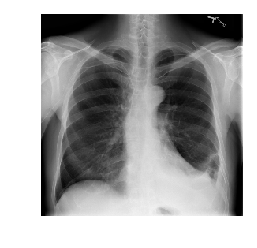

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


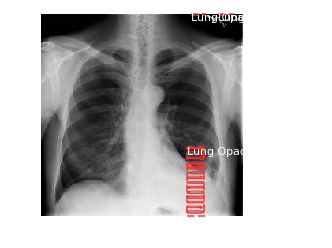

In [37]:
image_id = 6

original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_valid, inference_config, 
                           image_id, use_mini_mask=False)
visualize.display_instances(
    image=original_image,
    boxes=gt_bbox,
    masks=gt_mask,
    class_ids=gt_class_id, 
    class_names=dataset.class_names,
    figsize=(4,4),
    colors=get_colors_for_class_ids(gt_class_id),
    ax=fig.axes)

results = model.detect([original_image]) #, verbose=1)
r = results[0]
visualize.display_instances(
    image=original_image,
    boxes=r['rois'],
    masks=r['masks'],
    class_ids=r['class_ids'],
    class_names=dataset.class_names,
    figsize=(4,4),
    scores=r['scores'],
    colors=get_colors_for_class_ids(r['class_ids']),
    ax=fig.axes)